In [3]:
from DESY3Cats import DESY3Cats
import yaml
import h5py
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import fitsio as fio
from astropy.io import fits as fits
import treecorr as corr
from os.path import exists

def change_coord(mapp, coord):
    npix = mapp.shape[-1]
    nside = hp.npix2nside(npix)
    ang = hp.pix2ang(nside, np.arange(npix))
    rot = hp.Rotator(coord=reversed(coord))
    new_ang = rot(*ang)
    new_pix = hp.ang2pix(nside, *new_ang)
    return mapp[..., new_pix]

In [71]:
### Data files used in this note book are saved in
### ==============================================

# DES Y3 data root dir
ROOT_Y3 = "/home/jiachuan/data/jiachuan/DESY3_DR"

# DES Y3 Key Project catalog YAML file
# url: https://desdr-server.ncsa.illinois.edu/despublic/y3a2_files/y3kp_cats/cats.yaml
cats_index = ROOT_Y3+"/y3kp_cats/cats.yaml"

# DES Y3 Key Project index h5 file
# url: https://desdr-server.ncsa.illinois.edu/despublic/y3a2_files/y3kp_cats/DESY3_indexcat.h5
cats_h5 = ROOT_Y3+"/y3kp_cats/DESY3_indexcat.h5"

# DES Y3 Data Vector
# url: https://desdr-server.ncsa.illinois.edu/despublic/y3a2_files/datavectors/2pt_NG_final_2ptunblind_02_24_21_wnz_redmagic_covupdate.fits
y3dv_file = ROOT_Y3+"/datavectors/2pt_NG_final_2ptunblind_02_24_21_wnz_redmagic_covupdate.fits"

# DES Y1 zdistribution file (optional, as a comparison)
y1nz_src_file = "/home/jiachuan/cocoa/Cocoa/projects/desy1xplanck/data/mcal_1101_source.nz"
y1nz_lens_file = "/home/jiachuan/cocoa/Cocoa/projects/desy1xplanck/data/mcal_1101_lens.nz"

# DES Y1 2pcf measurements (optional)
ROOT_Y1_2pcf = "/home/jiachuan/2pt_measurements/data_test"
y1gk = ROOT_Y1_2pcf+"/gk_ref_sr_%d.txt"
y1sk = ROOT_Y1_2pcf+"/sk_ref_sr_%d.txt"
y1ss = ROOT_Y1_2pcf+"/shear_%d_%d.txt"
y1sg = ROOT_Y1_2pcf+"/ggl_S%d_L%d.txt"
y1gg = ROOT_Y1_2pcf+"/gg_%d_%d.txt"

# dir to save related files
TARGET_DIR = "/home/jiachuan/2pt_measurements/data_y3"

# Planck DR3 
# Planck DR page: http://pla.esac.esa.int/pla/#cosmology
# url: http://pla.esac.esa.int/pla/aio/product-action?COSMOLOGY.FILE_ID=COM_Lensing_4096_R3.00.tgz
ROOT_P18 = "/home/jiachuan/data/jiachuan/plancksmica/COM_Lensing_4096_R3.00"
P18_klm_file = ROOT_P18+"/MV/dat_klm.fits"
P18_mask_file = ROOT_P18+"/mask.fits"

# 6x2pt fiducial data vector (optional)
ROOT_cocoa = "/home/jiachuan/cocoa/Cocoa/projects/desy1xplanck"
dv_fid_6x2pt = ROOT_cocoa+"/data/xi_desy1xplanck_6x2pt_simudata_pp_agr2_CMBmarged_cocoa"
dv_fid_thetas = np.logspace(np.log10(2.5), np.log10(250), 20)
Ckk_MV_CMBmarg_P18 = ROOT_cocoa+"/data/pp_agr2_CMBmarged/Ckk_bandpower_datavector.txt"

# dir to save figures
ROOT_fig = "/home/jiachuan/2pt_measurements/figs"

## 0. Play with DES Y3 Catalog

The following cell is copied from [here](https://github.com/des-science/DESY3Cats/blob/main/example.py)

**NOTE:** The DES Y3 [y3kp_cats](https://desdr-server.ncsa.illinois.edu/despublic/y3a2_files/y3kp_cats/) seems to have an outdated `DESY3_indexcat.h5` file. The catalog filenames recorded in the index file do not exist, you have to build symbolic links for those files

> ln -s DESY3_GOLD_2_2.1.h5 Y3_GOLD_2_2.1_12_3_19.h5 <br>
> ln -s DESY3_GOLD_2_2.1_DNF.h5 Y3_GOLD_2_2.1_DNF_12_3_19.h5 <br>
> ln -s DESY3_maglim_redmagic_v0.5.1.h5 y3_gold_2.2.1_wide_sofcol_run_redmapper_v0.5.1_redmagic_02_05_21.h5 <br>
> ln -s DESY3_metacal_v03-004.h5 y3v02-mcal-004-v3_08_25_20.h5 <br>
> ln -s DESY3_sompz_v0.40.h5 sompz_v0.40_08_04_2020.h5 <br>

and also this notebook should be run in the same folder of the catalog data files, e.g. the `y3kp_cats`.

Some facts of DES Y3 data

- Survey area: 4143 $\mathrm{deg}^2$ (after masking bad region. this number will be used in covariance matrix calculation)
- Source galaxy shape noise: $\sigma_e=$ 0.268 (Heymans+12 definition, see the Table 1 in [Amon+22](https://arxiv.org/abs/2105.13543), the number used in CosmoLike is two-component shape noise $\sqrt{2}\sigma_e=0.379$, see the Table A1 in [Krause & Tim, 2017](https://arxiv.org/abs/1601.05779) )
- Source galaxy number density: $n_\mathrm{eff}=(1.476,\,1.479,\,1.484,\,1.461)\,\mathrm{arcmin}^{-2}$ (Heymans+12 definition)
- Lens galaxy number density: $n_\mathrm{lens}= (0.0221,\,0.0383,\,0.0585,\,0.0297,\,0.0253)\,\mathrm{arcmin}^{-2}$ ([Pandey+21](https://arxiv.org/pdf/2105.13545.pdf))
- Lens galaxy linear galaxy bias: (1.7, 1.7, 1.7, 2.0, 2.0).

In [5]:
# basic dict props
DESY3Cats_dict_ = {
    'output_exists' : True,
    'use_mpi'       : False,
    'source'        : 'hdf5',
    'dg'            : 0.01 #metacal applied shear
    }

# Populates a full DESY3Cats yaml dict for each catalog selection 
# based on the limited catalog input info provided in the common 
# cats.yaml file
def create_DESY3Cats_yaml( params, name, cal_type, group, table, 
                          select_path ):
    """
    Creates the input dictionary structure from a passed dictionary 
    rather than reading froma yaml file.
    """

    DESY3Cats_dict = DESY3Cats_dict_.copy()
    DESY3Cats_dict['load_cache'] = params['load_cache']
    DESY3Cats_dict['output'] = params['output']
    DESY3Cats_dict['name'] = name
    DESY3Cats_dict['filename'] = params['datafile']
    DESY3Cats_dict['param_file'] = params['param_file']
    DESY3Cats_dict['cal_type'] = cal_type
    DESY3Cats_dict['group'] = group
    DESY3Cats_dict['table'] = table
    DESY3Cats_dict['select_path'] = select_path
    DESY3Cats_dict['e'] = ['e_1','e_2']
    DESY3Cats_dict['Rg'] = ['R11','R22']
    DESY3Cats_dict['w'] = 'weight'

    return DESY3Cats_dict

# Build selector (and calibrator) classes from 
# DESY3Cats for the catalog.
def load_catalog(pipe_params, name, cal_type, group, table, select_path, 
                 inherit=None, return_calibrator=None):
    """
    Loads data access and calibration classes from DESY3Cats for 
    a given yaml setup file.
    """

    # Input yaml file defining catalog
    params = create_DESY3Cats_yaml(pipe_params, name, cal_type, group, table, 
                                   select_path)

    # Load DESY3Cats source class to manage access to file
    source = DESY3Cats.H5Source(params)

    # Load DESY3Cats selector class to manage access to data in a 
    # structured way
    if inherit is None:
        sel = DESY3Cats.Selector(params,source)
    else:
        sel = DESY3Cats.Selector(params,source,inherit=inherit)

    # Load DESY3Cats calibrator class to manage calibration of the catalog
    if return_calibrator is not None:
        cal = return_calibrator(params,sel)
        return sel, cal
    else:
        return sel

# Read yaml file that defines all the catalog selections used
params = yaml.load(open(cats_index),Loader=yaml.Loader)
params['param_file'] = cats_index

### Galaxy photo-$z$ distribution for each bin

3.0 2.99
3.0 2.99
3.0 2.99
3.0 2.99


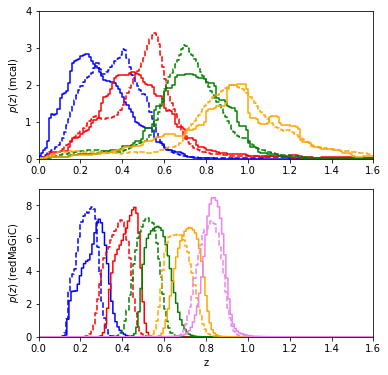

Solid lines: DES Y3 
Dashed lines: DES Y1


In [6]:

clist = ['b', 'r', 'g', 'orange', 'violet', 'grey']
fig, axes = plt.subplots(2,1, figsize=(6,6), sharex=False)

y1nz_src = np.genfromtxt(y1nz_src_file)
y1nz_lens = np.genfromtxt(y1nz_lens_file)

with fits.open(y3dv_file) as y3dv:
    # y3dv file
    # source nz: extention 6
    # lens nz: extention 7
    for i in range(4):
        ax = axes[0]
        # nz file which will be used in CoCoA, released in Y3 dv
        ax.plot(y3dv[6].data['Z_LOW'], y3dv[6].data['BIN%d'%(i+1)] / 0.01, color=clist[i], drawstyle='steps')
        ax.plot(y1nz_src[:,0], y1nz_src[:,i+1], color=clist[i], ls='--', drawstyle='steps')
        print(y3dv[6].data['Z_HIGH'][-1], y3dv[6].data['Z_LOW'][-1])
        
    for i in range(5):
        ax = axes[1]
        ax.plot(y3dv[7].data['Z_LOW'], y3dv[7].data['BIN%d'%(i+1)], color=clist[i], drawstyle='steps')
        ax.plot(y1nz_lens[:,0], y1nz_lens[:,i+1], color=clist[i], ls='--', drawstyle='steps')
axes[0].set(xlim=[0,1.6], 
            ylim=[0,4], ylabel=r'$p(z)$ (mcal)')
axes[1].set(xlim=[0,1.6], 
    ylim=[0,9], xlabel='z', ylabel=r'$p(z)$ (redMaGiC)')
plt.show()
print("Solid lines: DES Y3 \nDashed lines: DES Y1")

In [7]:
# save the DES Y3 nz file in cocoa format
if False:
    print("Save DES Y3 nz files:\nSource nz: ./mcal_3401_source.nz\nLens nz: ./mcal_3401_lens.nz")
    with fits.open(y3dv_file) as y3dv:
        np.savetxt(TARGET_DIR+"/mcal_3401_source.nz",
              np.c_[y3dv[6].data['Z_MID'], y3dv[6].data['BIN1']/0.01, y3dv[6].data['BIN2']/0.01, 
                    y3dv[6].data['BIN3']/0.01, y3dv[6].data['BIN4']/0.01], fmt='%le')
        np.savetxt(TARGET_DIR+"/mcal_3401_lens.nz",
                  np.c_[y3dv[7].data['Z_HIGH'], y3dv[7].data['BIN1'], y3dv[7].data['BIN2'], y3dv[7].data['BIN3'], 
                       y3dv[7].data['BIN4'], y3dv[7].data['BIN5']], fmt='%le')

## 1. Build lens galaxy `TreeCorr.Catalog` object using `RedMaGiC` sample and measure 2D galaxy clustering

Note that we need both the redmagic and the random sample.

For the description of columns of RedMaGiC catalog, see [here](https://des.ncsa.illinois.edu/releases/y3a2/Y3key-catalogs)

In [8]:
# Redmagic catalog
print("\nLoading RedMaGiC catalog...")
rm_selector, rm_calibrator = load_catalog(
    params, 'rm', None, params['rm_group'], params['rm_table'], 
    params['rm_path'], return_calibrator=DESY3Cats.NoCalib)
# Redmagic random catalog
print("\nLoading randomized RedMaGiC catalog...")
ran_selector = load_catalog(
    params, 'ran', None, params['rm_ran_group'], params['rm_ran_table'], 
    params['rm_ran_path'])

# define RedMaGiC galaxies tomo bins
zbin_def = [0.15, 0.35, 0.50, 0.65, 0.80, 0.90]

### Data galaxies
rm_data_z   = rm_selector.get_col('zredmagic')[0]
rm_data_ra  = rm_selector.get_col('ra')[0]
rm_data_dec = rm_selector.get_col('dec')[0]
skip, skip, rm_data_w = rm_calibrator.calibrate('none')

# apply bin selection
rm_data_zbin_masks = [
    np.logical_and(rm_data_z > zbin_def[i], rm_data_z < zbin_def[i+1]) \
    for i in range(5)
]
# test bin selection
print("Sanity check: tomo bin selection")
for i,m in enumerate(rm_data_zbin_masks):
    _z = rm_selector.get_masked(rm_data_z, m)
    print(f'tomography bin {i+1}: {np.min(_z)} < z < {np.max(_z)}')

# build TreeCorr.Catalog object for each tomography bin

lens_data_cats = [
    corr.Catalog(ra=rm_selector.get_masked(rm_data_ra, m),
                 dec=rm_selector.get_masked(rm_data_dec, m),
                 ra_units='deg', dec_units='deg', 
                 w=rm_selector.get_masked(rm_data_w, m)) \
    for m in rm_data_zbin_masks
]

### Randomized galaxies
rm_rand_z   = ran_selector.get_col('z')[0]
rm_rand_ra  = ran_selector.get_col('ra')[0]
rm_rand_dec = ran_selector.get_col('dec')[0]
rm_rand_w   = ran_selector.get_col('weight')[0]

rm_rand_zbin_masks = [
    np.logical_and(rm_rand_z > zbin_def[i], rm_rand_z < zbin_def[i+1]) \
    for i in range(5)
]

lens_rand_cats = [
    corr.Catalog(ra=ran_selector.get_masked(rm_rand_ra, m),
                 dec=ran_selector.get_masked(rm_rand_dec, m),
                 ra_units='deg', dec_units='deg', 
                 w=ran_selector.get_masked(rm_rand_w, m)) \
    for m in rm_rand_zbin_masks
]


Loading RedMaGiC catalog...
[H5Source] Building HDF file from DESY3_indexcat.h5
Group: catalog/redmagic
Table: ['combined_sample_fid']
The table has 14 columns:
--- chisq
--- coadd_object_id
--- dec
--- lum
--- mag
--- mag_err
--- ra
--- refmag
--- refmag_err
--- weight
--- zredmagic
--- zredmagic_e
--- zredmagic_samp
--- zspec
The table has 2686519 rows
[Selector] Building limiting mask...
[Selector] params index file from DESY3_indexcat.h5
using select_path for mask: index/redmagic/combined_sample_fid/select
source file size = 2686519
select_path file size = 2594036
No sheared select_path in index/redmagic/combined_sample_fid/select
mask_ save the limiting mask items ID
mask_ size = 2594036
mask save the limiting mask
mask has 1 extensions
the unsheared extension has size of 2594036
the unsheared extension has 2594036 selected items

Loading randomized RedMaGiC catalog...
[H5Source] Building HDF file from DESY3_indexcat.h5
Group: randoms/redmagic
Table: ['combined_sample_fid']
The t

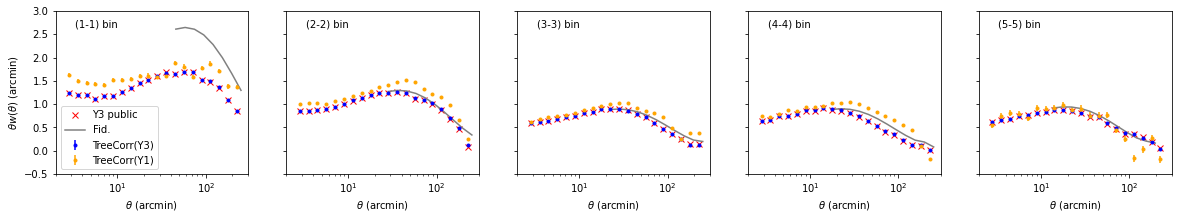

In [79]:
fig = plt.figure(figsize=(20,3))

for tomo_id in range(5):
    ### Compute galaxy-galaxy 2ptf
    ### ==========================
    output_fname_gg = TARGET_DIR+'/gg_%d_%d.txt'%(tomo_id,tomo_id)
    ### Note: just use calculated file is exist...
    if(exists(output_fname_gg)):
        # plot the 2pt from data file
        gg_from_file = np.genfromtxt(output_fname_gg, names=True)
        xi, varxi, r = gg_from_file['xi'], gg_from_file['varxi'], gg_from_file['theta']
    else:
        ### Construct DD, DR, RR pair counts
        dd_redmagic = corr.NNCorrelation(min_sep=2.5, max_sep=250, nbins=20, sep_units='arcmin', bin_slop=0.01, 
                                         num_threads=8)
        dd_redmagic.process(lens_data_cats[tomo_id])
        print('dd bin%d done'%(tomo_id+1))
        rr_redmagic = corr.NNCorrelation(min_sep=2.5, max_sep=250, nbins=20, sep_units='arcmin', bin_slop=0.01, 
                                         num_threads=8)
        rr_redmagic.process(lens_rand_cats[tomo_id])
        print('rr bin%d done'%(tomo_id+1))
        dr_redmagic = corr.NNCorrelation(min_sep=2.5, max_sep=250, nbins=20, sep_units='arcmin', bin_slop=0.01, 
                                         num_threads=8)
        dr_redmagic.process(lens_data_cats[tomo_id], lens_rand_cats[tomo_id])
        print('dr bin%d done'%(tomo_id+1))
    
        ### Calculate xi
        xi, varxi = dd_redmagic.calculateXi(rr_redmagic, dr_redmagic)
        r = np.exp(dd_redmagic.meanlogr)
        ### Save 2pt function: xi, varxi, r
        np.savetxt(output_fname_gg,np.c_[xi, varxi, r], header="xi varxi theta")
    
    ### Plot galaxy 2ptf and compare with public catalog
    ### ================================================
    ax = plt.subplot2grid((1, 5), (0,tomo_id))
    ax.errorbar(r, r*xi, yerr=r*np.sqrt(varxi), fmt='.b', label='TreeCorr(Y3)')
    with fits.open(y3dv_file) as y3dv:
        desy3_wtheta = y3dv[5].data
        desy3_wtheta_bin = np.where((desy3_wtheta['BIN1']==tomo_id+1)&(desy3_wtheta['BIN2']==tomo_id+1))[0]
        ax.plot(desy3_wtheta['ANG'][desy3_wtheta_bin],
            desy3_wtheta['ANG'][desy3_wtheta_bin]*desy3_wtheta['VALUE'][desy3_wtheta_bin],'x', 
            color='red',label='Y3 public')
    if(exists(dv_fid_6x2pt)):
        dv = np.genfromtxt(dv_fid_6x2pt)
        start = 800 + 20*tomo_id
        mask_idx = np.where(dv[start:start+20, 1] > 1e-10)[0]
        ax.plot(dv_fid_thetas[mask_idx], 
                dv_fid_thetas[mask_idx]*dv[start:start+20, 1][mask_idx], 
                label='Fid.', color='grey')
    if(exists(y1gg%(tomo_id, tomo_id))):
        dv = np.genfromtxt(y1gg%(tomo_id, tomo_id), names=True)
        ax.errorbar(dv['theta'], dv['xi']*dv['theta'], 
                   yerr = dv['theta']*dv['varxi']**0.5, fmt='.',color='orange', label='TreeCorr(Y1)')
    
    ax.text(0.1,0.9,'(%d-%d) bin'%(tomo_id+1, tomo_id+1),transform=ax.transAxes)
    ax.set_xscale('log')
    # ax.set_yscale('log', nonposy='clip')
    ax.set_xlabel(r'$\theta$ (arcmin)')
    if(tomo_id==0):
        ax.legend(loc='lower left')
        ax.set_ylabel(r'$\theta w(\theta)$ (arcmin)')
    else:
        ax.yaxis.set_ticklabels([])
    ax.set_xlim([2,300])
    ax.set_ylim(-0.5,3)
#plt.show()
plt.savefig(ROOT_fig+"/gg.png", dpi=250)

## 2. Build source galaxy `TreeCorr.Catalog` object using `metacalibration` sample and measure shear-shear correlation function

In [10]:
# Source catalog
source_selector, source_calibrator = load_catalog(
    params, 'mcal', 'mcal', params['source_group'], params['source_table'], 
    params['source_path'], return_calibrator=DESY3Cats.MetaCalib)

# SOMPZ information
pz_selector = load_catalog(
    params, 'pz', 'mcal', params['pz_group'], params['pz_table'], 
    params['pz_path'], inherit=source_selector)

mcal_data_ra = source_selector.get_col('ra')[0]
mcal_data_dec = source_selector.get_col('dec')[0]
mcal_data_g1 = source_selector.get_col('e_1')[0]
mcal_data_g2 = source_selector.get_col('e_2')[0]

src_data_cats = []

# Derive shear response
Rbins = []
wbins = []
cbins = []

[H5Source] Building HDF file from DESY3_indexcat.h5
Group: catalog/metacal
Table: ['unsheared', 'sheared_1p', 'sheared_1m', 'sheared_2p', 'sheared_2m']
The table has 37 columns:
--- R11
--- R12
--- R21
--- R22
--- T
--- T_err
--- coadd_object_id
--- covmat_0_1
--- covmat_1_1
--- covmat_2_2
--- dec
--- e_1
--- e_2
--- flags
--- flux_err_i
--- flux_err_r
--- flux_err_z
--- flux_i
--- flux_r
--- flux_z
--- mask_frac
--- mcal_psf_T
--- mcal_psf_e1
--- mcal_psf_e2
--- nimage_tot_i
--- nimage_tot_r
--- nimage_tot_z
--- nimage_use_i
--- nimage_use_r
--- nimage_use_z
--- psf_T
--- psf_e1
--- psf_e2
--- ra
--- size_ratio
--- snr
--- weight
The table has 399263026 rows
Sheared table detected! Sheared table has 16 columns:
--- T
--- T_err
--- covmat_0_1
--- covmat_1_1
--- covmat_2_2
--- e_1
--- e_2
--- flux_err_i
--- flux_err_r
--- flux_err_z
--- flux_i
--- flux_r
--- flux_z
--- size_ratio
--- snr
--- weight
[Selector] Building limiting mask...
[Selector] params index file from DESY3_indexcat.h5


KeyboardInterrupt: 

In [ ]:
# Get some source photo-z binning information, cut to range 0.1<z_mean<1.3
# for each tomo bin
print('\n Reducing shear response...')
for i in range(4):
    # 5-tuple for metacal sheared versions
    pzbin = pz_selector.get_col('bhat')
    # tomo bin selection mask for unsheared and sheared versions
    mask = [pzbin[j] == i for j in range(5)]
    
    # Note that get_col() returns a tuple. If its a catalog like gold, 
    # it will have length 1, but for something like metacal, it will have
    # length 5 (in the order of the table variable list passed in cats.yaml, 
    # i.e., 'unsheared', 'sheared_1p', 'sheared_1m', 'sheared_2p', 'sheared_2m')

    # Note that get_col() applies the index mask specified by the 'path' variable
    # in the cats.yaml file automatically.
    
    # Get responses (c, which doesn't exist for our catalogs), and weights
    # Optionally pass an additional mask to use when calculating the selection 
    # response. The returned R1 is <Rg_1 + Rs_1>. To get an array of R's, use 
    # return_wRg=True to get [Rg_1+Rg_2]/2 for each object or return_wRgS=True
    # to include the selection response. return_full=True returns the 
    # non-component-averaged version of the full response.
    
    # By default, the R returned is weighted shear response
    # i.e. R = <w(Rg+Rs)>/<w>
    R1,c,w = source_calibrator.calibrate('e_1', mask=mask) 
    #print(R1,c,w)
    #g1=source_selector.get_col('e_1')
    #print(len(w),[len(g1[j]) for j in range(4)])
    R2,c,w = source_calibrator.calibrate('e_2', mask=mask)
    #print(R2,c,w)
    
    Rbins.append((R1+R2)/2.0)
    wbins.append(w)
    cbins.append(c)
    
    # get masked quantities
    _ra = mcal_data_ra[mask[0]]
    _dec = mcal_data_dec[mask[0]]
    _g1 = mcal_data_g1[mask[0]]
    _g2 = mcal_data_g2[mask[0]]
    _g1 -= np.average(_g1, weights=w)
    _g2 -= np.average(_g2, weights=w)
    
    # construct shear catalog
    cat_mcal = corr.Catalog(ra=_ra, dec=_dec, ra_units='deg', dec_units='deg', 
                            g1=_g1, g2=_g2, w=w)
    src_data_cats.append(cat_mcal)

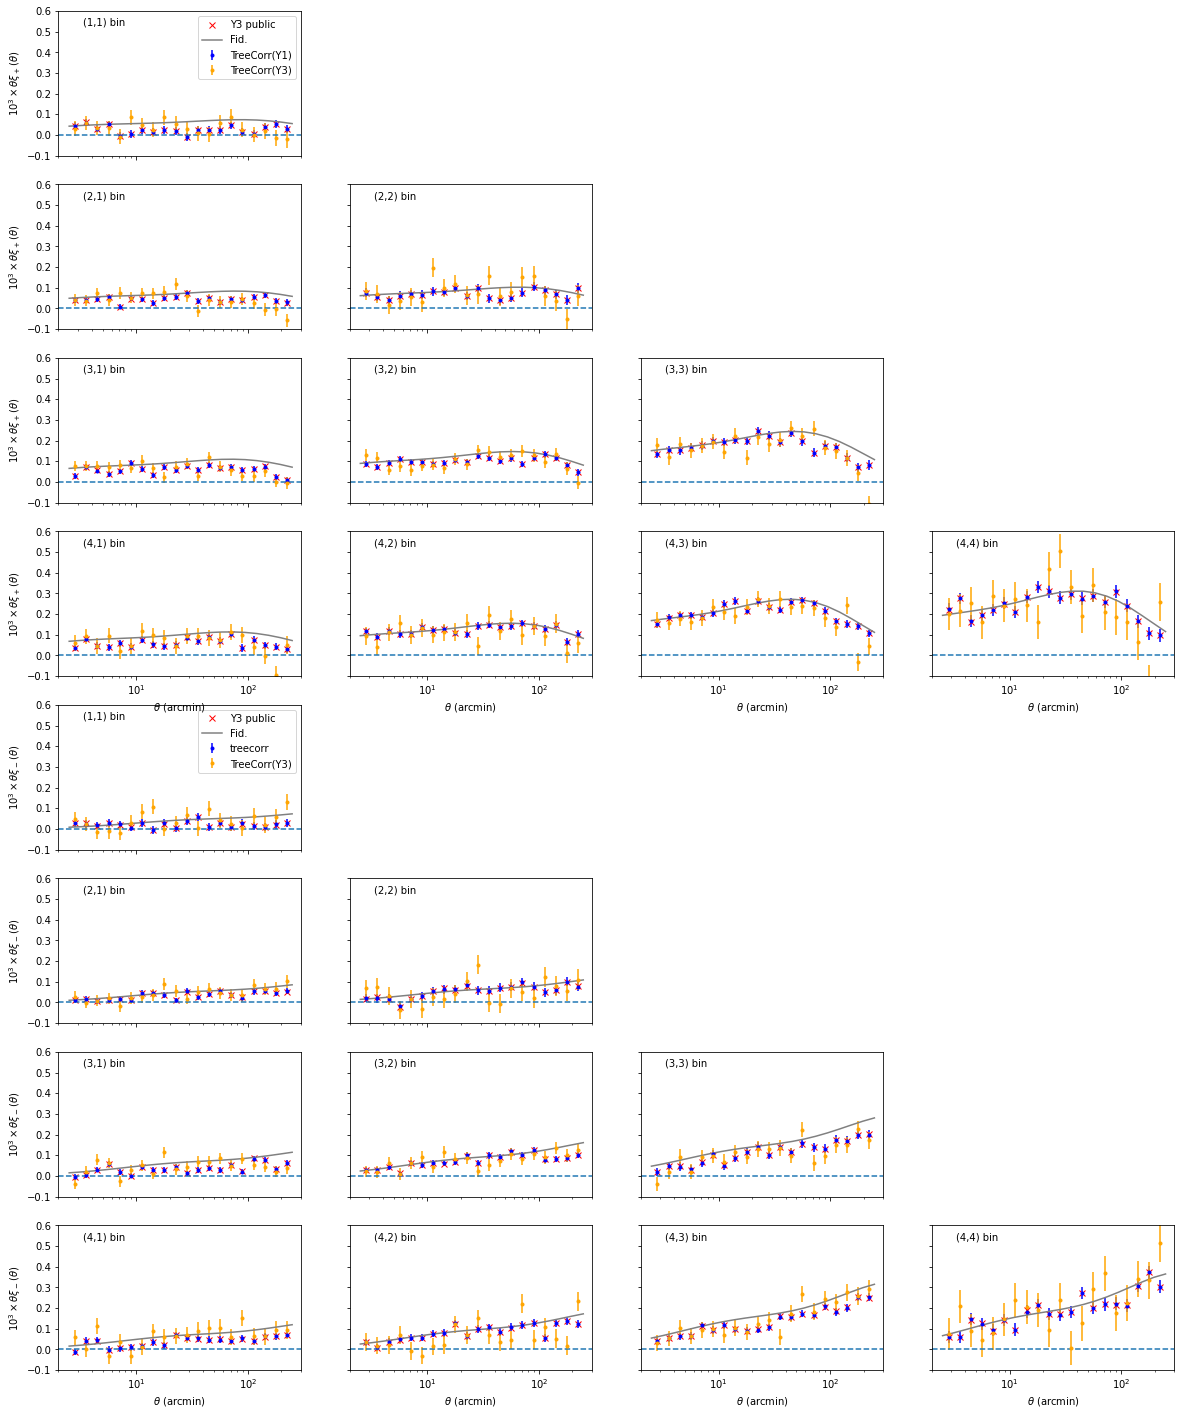

In [80]:
# Calculate and plot shear-shear 2pt
### ==================================
fig = plt.figure(figsize=(20,25))
# load xi_pm from public data vector
with fits.open(y3dv_file) as y3dv:
    desy3_xip = y3dv[2].data
    desy3_xim = y3dv[3].data

serial_id = 0
for tomo_i in range(4):
    for tomo_j in range(tomo_i, 4):
        ### Calculate shear-shear 2pt
        ### =========================
        output_fname_ss = TARGET_DIR+'/shear_%d_%d.txt'%(tomo_i, tomo_j)
        ### Note: just use calculated file is exist...
        if(exists(output_fname_ss)):
            # plot the 2pt from data file
            ss_from_file = np.genfromtxt(output_fname_ss, names=True)
            xip, xim, varxip, varxim, r = ss_from_file['xip'], ss_from_file['xim'], ss_from_file['varxip'], \
            ss_from_file['varxim'], ss_from_file['r']
        else:
            print("Calculate xi_pm (%d, %d)"%(tomo_i+1, tomo_j+1))
            gg = corr.GGCorrelation(min_sep=2.5, max_sep=250, nbins=20, sep_units='arcmin', 
                                    bin_slop=0., num_threads=8)
            if(tomo_i==tomo_j):
                gg.process(src_data_cats[tomo_i])
            else:
                gg.process(src_data_cats[tomo_i], src_data_cats[tomo_j])
            print('shear %d-%d done!'%(tomo_i+1,tomo_j+1))
            r = np.exp(gg.meanlogr)
            xip = gg.xip/(Rbins[tomo_i]*Rbins[tomo_j])
            xim = gg.xim/(Rbins[tomo_i]*Rbins[tomo_j])
            varxip = gg.varxip/(Rbins[tomo_i]*Rbins[tomo_j])**2
            varxim = gg.varxim/(Rbins[tomo_i]*Rbins[tomo_j])**2
            # save data
            np.savetxt(output_fname_ss, np.c_[xip, xim, varxip, varxim, r],
                       header=" xip xim varxip varxim r")
            
        desy3_xip_idx = np.where((desy3_xip['BIN1']==tomo_i+1)&(desy3_xip['BIN2']==tomo_j+1))[0]
        desy3_xim_idx = np.where((desy3_xim['BIN1']==tomo_i+1)&(desy3_xim['BIN2']==tomo_j+1))[0]
        
        ### plot xi_pm
        ### ==========
        ax = plt.subplot2grid((8, 4), (tomo_j, tomo_i))
        # xip
        ax.errorbar(r, r*xip*1e3, yerr=r*np.sqrt(varxip)*1e3, fmt='.b',  label='TreeCorr(Y1)')
        ax.plot(desy3_xip['ANG'][desy3_xip_idx], 
                desy3_xip['ANG'][desy3_xip_idx]*desy3_xip['VALUE'][desy3_xip_idx]*1e3,
                'x', color='red', label='Y3 public')
        if(exists(dv_fid_6x2pt)):
            dv = np.genfromtxt(dv_fid_6x2pt)
            start = 0 + 20*serial_id
            mask_idx = np.where(dv[start:start+20, 1] > 1e-10)[0]
            ax.plot(dv_fid_thetas[mask_idx], 
                    dv_fid_thetas[mask_idx]*dv[start:start+20, 1][mask_idx]*1e3, 
                    label='Fid.', color='grey')
        if(exists(y1ss%(tomo_i, tomo_j))):
            dv = np.genfromtxt(y1ss%(tomo_i, tomo_j), names=True)
            ax.errorbar(dv['r'], dv['xip']*dv['r']*1e3,
                        yerr=dv['varxip']**0.5*dv['r']*1e3, fmt='.', color='orange', label='TreeCorr(Y3)')
        ax.axhline(y=0, ls='--')
        ax.set_xscale('log')
        if(tomo_i==0 and tomo_j==0):
            ax.legend()
        ax.set_xlim( [2,300] )
        ax.set_ylim([-1e-1,6e-1])
        if(tomo_j==3):
            ax.set_xlabel(r'$\theta$ (arcmin)')
        else:
            ax.xaxis.set_ticklabels([])
        if(tomo_i==0):
            ax.set_ylabel(r'$10^{3}\times\theta\xi_+(\theta)$')
        else:
            ax.yaxis.set_ticklabels([])
        ax.text(0.1,0.9,"(%d,%d) bin"%(tomo_j+1,tomo_i+1),transform=ax.transAxes)
        # xim
        ax = plt.subplot2grid((8, 4), (4+tomo_j, tomo_i))
        ax.errorbar(r, r*xim*1e3, yerr=r*np.sqrt(varxim)*1e3,fmt='.b', label='treecorr')
        ax.plot(desy3_xim['ANG'][desy3_xim_idx], 
                desy3_xim['ANG'][desy3_xim_idx]*desy3_xim['VALUE'][desy3_xim_idx]*1e3,
                'x', color='red', label='Y3 public')
        if(exists(dv_fid_6x2pt)):
            dv = np.genfromtxt(dv_fid_6x2pt)
            start = 200 + 20*serial_id
            mask_idx = np.where(dv[start:start+20, 1] > 1e-10)[0]
            ax.plot(dv_fid_thetas[mask_idx], 
                    dv_fid_thetas[mask_idx]*dv[start:start+20, 1][mask_idx]*1e3, 
                    label='Fid.', color='grey')
        if(exists(y1ss%(tomo_i, tomo_j))):
            dv = np.genfromtxt(y1ss%(tomo_i, tomo_j), names=True)
            ax.errorbar(dv['r'], dv['xim']*dv['r']*1e3,
                        yerr=dv['varxim']**0.5*dv['r']*1e3, fmt='.', color='orange', label='TreeCorr(Y3)')
        ax.axhline(y=0,ls='--')
        ax.set_xscale('log')
        if(tomo_i==0 and tomo_j==0):
            ax.legend()
        ax.set_xlim( [2,300] )
        ax.set_ylim([-1e-1,6e-1])
        if(tomo_j==3):
            ax.set_xlabel(r'$\theta$ (arcmin)')
        else:
            ax.xaxis.set_ticklabels([])
        if(tomo_i==0):
            ax.set_ylabel(r'$10^{3}\times\theta\xi_-(\theta)$')
        else:
            ax.yaxis.set_ticklabels([])
        ax.text(0.1,0.9,"(%d,%d) bin"%(tomo_j+1, tomo_i+1),transform=ax.transAxes)
        
        serial_id += 1
#plt.show()
plt.savefig(ROOT_fig+"/ss.png", dpi=250)

## 3. Measure galaxy-galaxy lensing

ggl done!


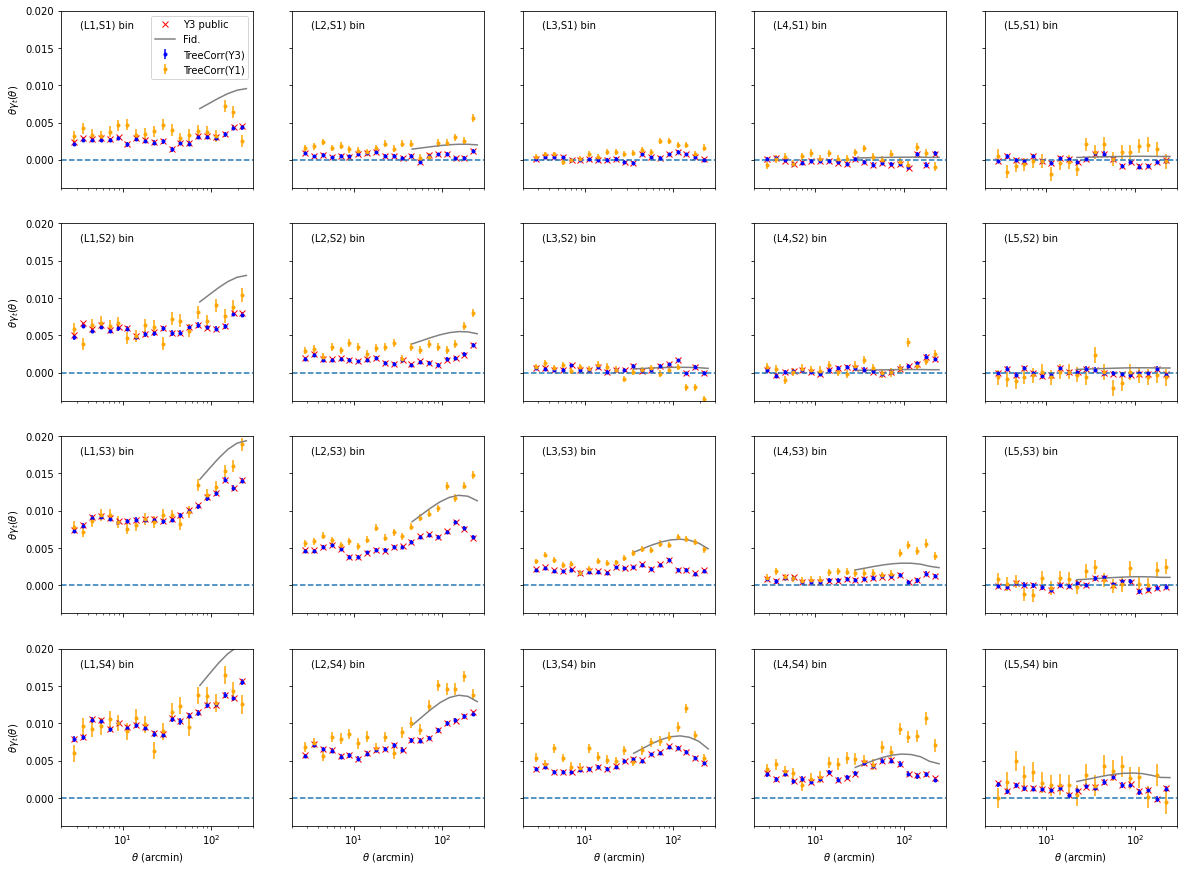

In [81]:
### Calculate and plot galaxy-galaxy lensing
### ========================================
fig = plt.figure(figsize=(20,15))
with fits.open(y3dv_file) as y3dv:
    desy3_gammat = y3dv[4].data

serial_id = 0
#for tomo_i in range(4):
#    for tomo_j in range(5):
for tomo_j in range(5):
    for tomo_i in range(4):
        ### Calculate galaxy-galaxy lensing 2pt
        ### ===================================
        output_fname_gs =TARGET_DIR+'/ggl_S%d_L%d.txt'%(tomo_i, tomo_j)
        ### Note: just use calculated file is exist...
        if(exists(output_fname_gs)):
            # plot the 2pt from data file
            gs_from_file = np.genfromtxt(output_fname_gs, names=True)
            xi, varxi, r = gs_from_file['xi'], gs_from_file['varxi'], gs_from_file['r']
        else:
            gt = corr.NGCorrelation(min_sep=2.5, max_sep=250, nbins=20, sep_units='arcmin', 
                                    bin_slop=0., num_threads=8)
            gt_rand = corr.NGCorrelation(min_sep=2.5, max_sep=250, nbins=20, sep_units='arcmin', 
                                         bin_slop=0., num_threads=8)
            gt.process(lens_data_cats[tomo_j], src_data_cats[tomo_i])
            gt_rand.process(lens_rand_cats[tomo_j],src_data_cats[tomo_i])
            r = np.exp(gt.meanlogr)
            xi = (gt.xi - gt_rand.xi)/Rbins[tomo_i]
            varxi = (gt.varxi+gt_rand.varxi)/Rbins[tomo_i]**2
            # save data
            np.savetxt(output_fname_gs, np.c_[xi, varxi, r], header=" xi varxi r")
            print('ggl S%d-L%d done!'%(tomo_i+1,tomo_j+1))
        # select gamma_t from des y1 data
        desy3_gammat_idx = np.where((desy3_gammat['BIN1']==tomo_j+1)&(desy3_gammat['BIN2']==tomo_i+1))[0]
        
        ### Plot ggl 2ptf
        ### =============
        ax = plt.subplot2grid((4, 5), (tomo_i, tomo_j))
        ax.errorbar(r, r*xi, yerr=r*np.sqrt(varxi), fmt='.b', label='TreeCorr(Y3)')
        ax.plot(desy3_gammat['ANG'][desy3_gammat_idx], 
                desy3_gammat['ANG'][desy3_gammat_idx]*desy3_gammat['VALUE'][desy3_gammat_idx], 
                'x', color='red', label='Y3 public')
        if(exists(dv_fid_6x2pt)):
            dv = np.genfromtxt(dv_fid_6x2pt)
            start = 400 + 20*serial_id
            mask_idx = np.where(dv[start:start+20, 1] > 1e-10)[0]
            ax.plot(dv_fid_thetas[mask_idx], 
                    dv_fid_thetas[mask_idx]*dv[start:start+20, 1][mask_idx], 
                    label='Fid.', color='grey')
        if(exists(y1sg%(tomo_i, tomo_j))):
            dv = np.genfromtxt(y1sg%(tomo_i, tomo_j), names=True)
            ax.errorbar(dv['r'], dv['r']*dv['xi'], yerr=dv['r']*dv['varxi']**0.5, fmt='.',
                       color='orange', label='TreeCorr(Y1)')
            
        ax.axhline(y=0,ls='--')
        ax.set_xscale('log')
        # plt.yscale('log', nonposy='clip')
        # plt.legend([lp, lm], [r'$\xi_+(\theta)$', r'$\xi_-(\theta)$'])
        if(tomo_i==0 and tomo_j==0):
            ax.legend()
        ax.set_xlim( [2,300] )
        ax.set_ylim([-0.375e-2,2e-2])
        if(tomo_i==3):
            ax.set_xlabel(r'$\theta$ (arcmin)')
        else:
            ax.xaxis.set_ticklabels([])
        if(tomo_j==0):
            ax.set_ylabel(r'$\theta\gamma_t(\theta)$')
        else:
            ax.yaxis.set_ticklabels([])
        ax.text(0.1, 0.9, "(L%d,S%d) bin"%(tomo_j+1, tomo_i+1),transform=ax.transAxes)
        
        serial_id += 1
#plt.show()
plt.savefig(ROOT_fig+"/sg.png", dpi=250)
print('ggl done!')

## 4. Load Planck DR3 lensing reconstruction

check out the survey mask

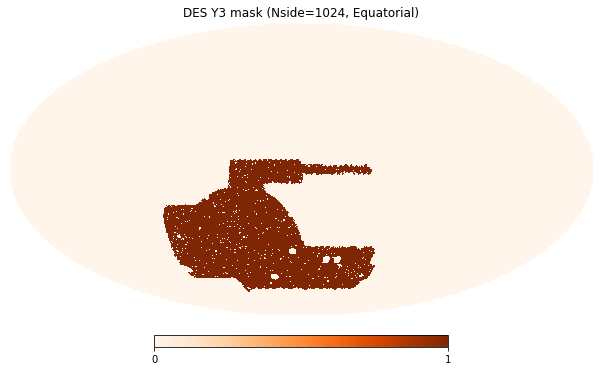

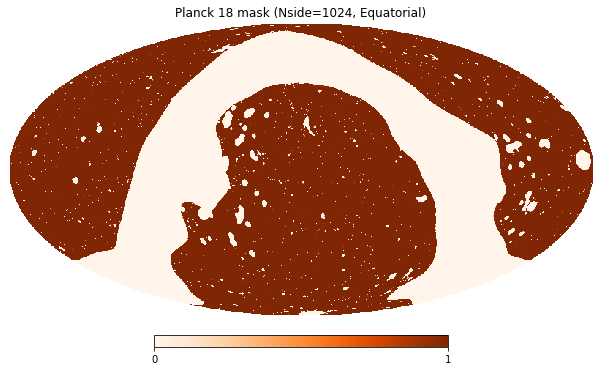

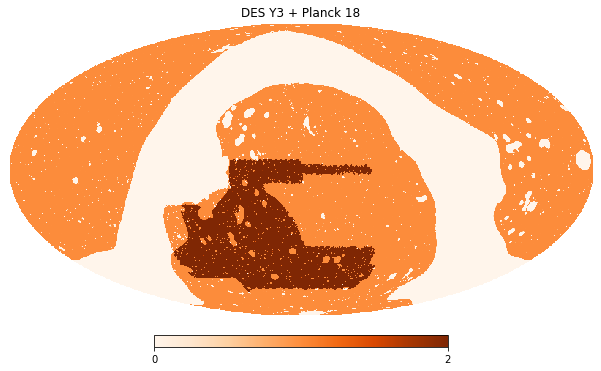

In [84]:
Nside = 1024

# Y3 RedMaGiC Mask, NESTED, Equatorial
Nside_Y3 = 4096 # a guess
Npix_Y3 = hp.nside2npix(Nside_Y3)
hdf = h5py.File(cats_h5, mode = 'r')
mask_Y3 = np.zeros(Npix_Y3)
mask_Y3[hdf['masks/redmagic/combined_sample_fid/hpix']] = hdf['masks/redmagic/combined_sample_fid/fracgood']

mask_Y3_bool = hp.pixelfunc.mask_good(mask_Y3, badval=0, atol=0.1)
mask_Y3_bool = hp.pixelfunc.ud_grade(mask_Y3_bool, Nside, order_in='NESTED', order_out='RING')

hp.mollview(mask_Y3_bool, title='DES Y3 mask (Nside=%d, Equatorial)'%Nside,  cmap='Oranges')

# Planck DR3 mask, RING, Galactocentric
mask_P18 = hp.fitsfunc.read_map(P18_mask_file)
mask_P18_bool = hp.pixelfunc.mask_good(mask_P18, badval=0, atol=0.1)
mask_P18_bool = hp.pixelfunc.ud_grade(mask_P18_bool, Nside, order_in='RING', order_out='RING')
r =hp.rotator.Rotator(coord=['G', 'E'])
mask_P18_bool = r.rotate_map_pixel(mask_P18_bool)

hp.mollview(mask_P18_bool, title='Planck 18 mask (Nside=%d, Equatorial)'%Nside, cmap='Oranges')

# Plot the two
hp.mollview(mask_P18_bool + mask_Y3_bool,title='DES Y3 + Planck 18', cmap='Oranges')

**Caveat**: DES Y3 and Planck DR3 footprint boundaries are very close at the galactic disk edge, which may impair the assumption that survey 1 footprint is a subset of the one of survey 2, when deriving the covariance matrix.

### Build Planck CMB convergence catalog

**Note:** the CMB convergence map is smoothed by a Gaussian beam kernel of FWHM=$7\,\mathrm{arcmin}$, and is further cutted at $L=40$ and $L=3999$. 

In [ ]:
lmax_P18, Nside_P18 = 4096, 1024
beam_fwhm = 7.0/60./180.*np.pi
beam_lmin, beam_lmax = 40, min(2999, 3*Nside_P18-1)

### Read klm
# baseline reconstruction
# mask: True/2 = good value; False/0 = bad value
# downgrade mask map from Nside=2048 to 1024, to match k-map
ell_all, m_all = hp.sphtfunc.Alm.getlm(lmax_P18)
k_ref_klm = hp.read_alm(P18_klm_file)

### Smooth by beam size & scale-cut
beam_scalecut_id = np.where(np.logical_or(ell_all < beam_lmin, ell_all > beam_lmax))[0]
k_ref_klm_s = hp.sphtfunc.smoothalm(k_ref_klm, fwhm = beam_fwhm)
k_ref_klm_s[beam_scalecut_id] = 0.0 # smoothing kernel scale-cut

### Convert alm to map
k_ref_map_s = hp.sphtfunc.alm2map(k_ref_klm_s, Nside_P18)


### rotate the coordinates
#k_ref_map_sr = r.rotate_map_pixel(k_ref_map_s)
k_ref_map_sr = change_coord(k_ref_map_s, ['G', 'C'])

### mask the map
k_ref_map_srm = hp.ma(k_ref_map_sr)
k_ref_map_srm.mask = np.logical_not(mask_P18_bool)

hp.mollview(k_ref_map_srm, title='Baseline Convergence Map (Beam FWHM = 7 arcmin)')

In [ ]:
Npix_P18 = hp.nside2npix(Nside_P18)
ipixes = np.arange(Npix_P18);
thetas, phis  = hp.pix2ang(Nside_P18, ipixes)
ra = np.rad2deg(phis)
dec = np.rad2deg(0.5 * np.pi - thetas)
cmbmask_ref = (mask_P18_bool==True)

### build CMB kappa catalog object using the rotated kappa map
cat_k_ref = corr.Catalog(ra=ra[cmbmask_ref], dec=dec[cmbmask_ref], 
                     ra_units='deg', dec_units='deg', 
                     k=k_ref_map_sr[cmbmask_ref])

## 5. Measure galaxy-CMB lensing convergence correlation function

gk done!


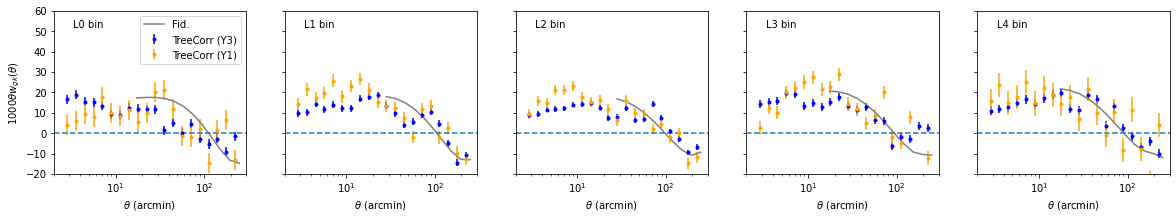

In [82]:
### Calculate and plot gk 2ptf
### ==========================
fig = plt.figure(figsize=(20,3))

for tomo_i in range(5):
    ### Calculate galaxy-kappa map 2pt
    ### ===================================
    output_fname_gk_ref_sr = TARGET_DIR+"/gk_%d.txt"%(tomo_i)
    
    ### Smooth in new method
    ### ====================
    if(exists(output_fname_gk_ref_sr)):
        gk_smooth_from_file = np.genfromtxt(output_fname_gk_ref_sr, names=True)
        xi_ref_sr, varxi_ref_sr, r_ref_sr = gk_smooth_from_file['xi'], gk_smooth_from_file['varxi'], gk_smooth_from_file['r']
    else:
        gk_ref = corr.NKCorrelation(min_sep=2.5, max_sep=250, nbins=20, sep_units='arcmin',bin_slop=0.01)
        gk_rnd = corr.NKCorrelation(min_sep=2.5, max_sep=250, nbins=20, sep_units='arcmin',bin_slop=0.01)
        gk_ref.process(lens_data_cats[tomo_i], cat_k_ref)
        gk_rnd.process(lens_rand_cats[tomo_i], cat_k_ref)
        r_ref_sr = np.exp(gk_ref.meanlogr)
        xi_ref_sr = gk_ref.xi - gk_rnd.xi
        varxi_ref_sr = gk_ref.varxi+gk_rnd.varxi
        np.savetxt(output_fname_gk_ref_sr, np.c_[xi_ref_sr, varxi_ref_sr, r_ref_sr], header='xi varxi r')
        print('gk_CMB bin %d done!'%(tomo_i))
        
    ### Plot ggl 2ptf
    ### =============
    ax = plt.subplot2grid((1, 5), (0, tomo_i))
    ax.errorbar(r_ref_sr, 1e3*r_ref_sr*xi_ref_sr, 
                yerr=1e3*r_ref_sr*np.sqrt(varxi_ref_sr), fmt='.b', label='TreeCorr (Y3)')
    if(exists(y1gk%tomo_i)):
        gk_sr_y1 = np.genfromtxt(y1gk%tomo_i, names=True)
        ax.errorbar(gk_sr_y1['r'], 1e3*gk_sr_y1['r']*gk_sr_y1['xi'],
                    yerr=1e3*gk_sr_y1['r']*gk_sr_y1['varxi']**0.5, fmt='.',
                    color='orange', label='TreeCorr (Y1)')
    if(exists(dv_fid_6x2pt)):
        dv = np.genfromtxt(dv_fid_6x2pt)
        start = 900 + 20*tomo_i
        mask_idx = np.where(abs(dv[start:start+20, 1]) > 1e-10)[0]
        ax.plot(dv_fid_thetas[mask_idx], 
                dv_fid_thetas[mask_idx]*dv[start:start+20, 1][mask_idx]*1e3, 
                label='Fid.', color='grey')
            
    ax.axhline(y=0, ls='--')
    ax.set_xscale('log')
    # plt.yscale('log', nonposy='clip')
    ax.set_xlabel(r'$\theta$ (arcmin)')
    ax.set_xlim( [2,300] )
    ax.set_ylim( [-20,60] )
    if(tomo_i==0):
        ax.legend(loc='upper right')
        ax.set_ylabel(r'$1000 \theta w_{gk}(\theta)$')
    else:
        ax.yaxis.set_ticklabels([])
    ax.text(0.1,0.9,'L%d bin'%(tomo_i), transform=ax.transAxes)
print('gk done!')
#plt.show()
plt.savefig(ROOT_fig+"/gk.png", dpi=250)

## 6. Measure galaxy shear-CMB lensing convergence correlation function

sk done!


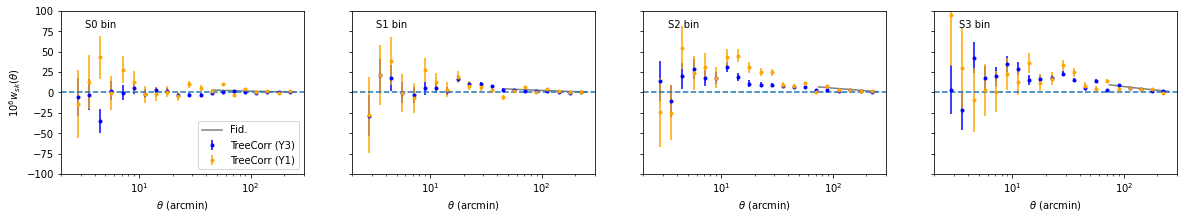

In [83]:
### Calculate and plot gs 2ptf
### ==========================
fig = plt.figure(figsize=(20,3))

for tomo_i in range(4):
    ### Calculate galaxy shear-kappa map 2pt
    ### ===================================
    output_fname_sk_ref_sr = TARGET_DIR+"/sk_%d.txt"%(tomo_i)

    ### Note: just use calculated file is exist...
    if(exists(output_fname_sk_ref_sr)):
        sk_from_file = np.genfromtxt(output_fname_sk_ref_sr, names=True)
        xi, varxi, r = sk_from_file['xi'], sk_from_file['varxi'], sk_from_file['r']
    else:
        sk = corr.KGCorrelation(min_sep=2.5, max_sep=250, nbins=20, sep_units='arcmin',bin_slop=0.01)
        sk.process(cat_k_ref, src_data_cats[tomo_i]) # un-smoothed
        r = np.exp(sk.meanlogr)
        xi = sk.xi/Rbins[tomo_i]
        varxi = sk.varxi/Rbins[tomo_i]**2
        np.savetxt(output_fname_sk_ref_sr, np.c_[xi, varxi, r], header='xi varxi r')
        print('bin S%d done!'%(tomo_i))
    ### Plot ggl 2ptf
    ### =============
    ax = plt.subplot2grid((1, 4), (0, tomo_i))
    ax.errorbar(r, 1e6*xi, yerr=1e6*np.sqrt(varxi), fmt='.b', label='TreeCorr (Y3)')
    if(exists(y1sk%tomo_i)):
        sk_sr_y1 = np.genfromtxt(y1sk%tomo_i, names=True)
        ax.errorbar(sk_sr_y1['r'], 1e6*sk_sr_y1['xi'],
                    yerr=1e6*sk_sr_y1['varxi']**0.5, fmt='.', color='orange', label='TreeCorr (Y1)')
    if(exists(dv_fid_6x2pt)):
        dv = np.genfromtxt(dv_fid_6x2pt)
        start = 1000 + 20*tomo_i
        mask_idx = np.where(abs(dv[start:start+20, 1]) > 1e-16)[0]
        ax.plot(dv_fid_thetas[mask_idx], 
                dv[start:start+20, 1][mask_idx]*1e6, 
                label='Fid.', color='grey')
        
    ax.axhline(y=0, ls='--')
    ax.set_xscale('log')
    # plt.yscale('log', nonposy='clip')
    ax.set_xlabel(r'$\theta$ (arcmin)')
    ax.set_xlim( [2,300] )
    ax.set_ylim( [-100,100] )
    if(tomo_i==0):
        ax.legend(loc='lower right')
        ax.set_ylabel(r'$10^6 w_{sk}(\theta)$')
    else:
        ax.yaxis.set_ticklabels([])
    ax.text(0.1,0.9,'S%d bin'%(tomo_i), transform=ax.transAxes)
print('sk done!')
#plt.show()
plt.savefig(ROOT_fig+"/sk.png", dpi=250)

### Save the measurements as data vector

In [40]:
Nkk_agr2 = 14
N5x2pt = 1080
y3xp18_6x2pt = np.zeros(N5x2pt+Nkk_agr2)
start = 0
# xi_pm
for tomo_i in range(4):
    for tomo_j in range(tomo_i, 4):
        output_fname_ss = TARGET_DIR+'/shear_%d_%d.txt'%(tomo_i, tomo_j)
        if(exists(output_fname_ss)):
            ss_from_file = np.genfromtxt(output_fname_ss, names=True)
            # xip
            y3xp18_6x2pt[start:start+20] = ss_from_file['xip']
            # xim
            y3xp18_6x2pt[start+200:start+220] = ss_from_file['xim']
        start += 20
start += 200
# gamma_t
for tomo_j in range(5):
    for tomo_i in range(4):
        output_fname_gs =TARGET_DIR+'/ggl_S%d_L%d.txt'%(tomo_i, tomo_j)
        if(exists(output_fname_gs)):
            gs_from_file = np.genfromtxt(output_fname_gs, names=True)
            y3xp18_6x2pt[start:start+20] = gs_from_file['xi']
        start += 20
# clustering
for tomo_id in range(5):
    output_fname_gg = TARGET_DIR+'/gg_%d_%d.txt'%(tomo_id,tomo_id)
    if(exists(output_fname_gg)):
        gg_from_file = np.genfromtxt(output_fname_gg, names=True)
        y3xp18_6x2pt[start:start+20] = gg_from_file['xi']
    start += 20
# gk
for tomo_i in range(5):
    output_fname_gk_ref_sr = TARGET_DIR+"/gk_%d.txt"%(tomo_i)
    if(exists(output_fname_gk_ref_sr)):
        gk_smooth_from_file = np.genfromtxt(output_fname_gk_ref_sr, names=True)
        y3xp18_6x2pt[start:start+20] = gk_smooth_from_file['xi']
    start += 20
# sk
for tomo_i in range(4):
    output_fname_sk_ref_sr = TARGET_DIR+"/sk_%d.txt"%(tomo_i)
    if(exists(output_fname_sk_ref_sr)):
        sk_from_file = np.genfromtxt(output_fname_sk_ref_sr, names=True)
        y3xp18_6x2pt[start:start+20] = sk_from_file['xi']
    start += 20
# kk
Ckk = np.genfromtxt(Ckk_MV_CMBmarg_P18)
y3xp18_6x2pt[start:start+Nkk_agr2] = Ckk
start += Nkk_agr2
print(start)

if False:
    np.savetxt(TARGET_DIR+"/xi_desy3xplanck_6x2pt_realdata_pp_agr2_CMBmarged", 
           np.c_[range(start), y3xp18_6x2pt], fmt='%d %le')

1094


In [41]:
y3dv_public = fits.open(y3dv_file)

In [42]:
y3dv_public.info()

Filename: /home/jiachuan/data/jiachuan/DESY3_DR/datavectors/2pt_NG_final_2ptunblind_02_24_21_wnz_redmagic_covupdate.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  COVMAT        1 ImageHDU        17   (900, 900)   float64   
  2  xip           1 BinTableHDU     37   200R x 8C   [K, K, K, D, D, D, D, D]   
  3  xim           1 BinTableHDU     37   200R x 8C   [K, K, K, D, D, D, D, D]   
  4  gammat        1 BinTableHDU     35   400R x 7C   [K, K, K, D, D, D, D]   
  5  wtheta        1 BinTableHDU     37   100R x 8C   [K, K, K, D, D, D, D, D]   
  6  nz_source     1 BinTableHDU     32   300R x 7C   [D, D, D, D, D, D, D]   
  7  nz_lens       1 BinTableHDU     31   601R x 8C   [D, D, D, D, D, D, D, D]   
  8  nz_source_realisation_0    1 BinTableHDU     32   300R x 7C   [D, D, D, D, D, D, D]   
  9  nz_source_realisation_1    1 BinTableHDU     32   300R x 7C   [D, D, D, D, D, D, D]   
 10  nz_source_realisation_2  

In [54]:
print("Y3 data vector sequence convention:")

print("=== xip:")
ct = 0
for i,j in zip(y3dv_public[2].data['BIN1'], y3dv_public[2].data['BIN2']):
    if(ct==19):
        print('bin S%d - S%d'%(i,j))
        ct = 0
    ct += 1

print("=== xim:")
ct = 0
for i,j in zip(y3dv_public[3].data['BIN1'], y3dv_public[3].data['BIN2']):
    if(ct==19):
        print('bin S%d - S%d'%(i,j))
        ct = 0
    ct += 1

print("=== gammat:")
ct = 0
for i,j in zip(y3dv_public[4].data['BIN1'], y3dv_public[4].data['BIN2']):
    if(ct==19):
        print('bin L%d - S%d'%(i,j))
        ct = 0
    ct += 1

print("=== wtheta:")
ct = 0
for i,j in zip(y3dv_public[3].data['BIN1'], y3dv_public[3].data['BIN2']):
    if(ct==19):
        print('bin L%d - L%d'%(i,j))
        ct = 0
    ct += 1

Y3 data vector sequence convention:
=== xip:
bin S1 - S1
bin S1 - S2
bin S1 - S3
bin S1 - S4
bin S2 - S2
bin S2 - S3
bin S2 - S4
bin S3 - S3
bin S3 - S4
bin S4 - S4
=== xim:
bin S1 - S1
bin S1 - S2
bin S1 - S3
bin S1 - S4
bin S2 - S2
bin S2 - S3
bin S2 - S4
bin S3 - S3
bin S3 - S4
bin S4 - S4
=== gammat:
bin L1 - S1
bin L1 - S2
bin L1 - S3
bin L1 - S4
bin L2 - S1
bin L2 - S2
bin L2 - S3
bin L2 - S4
bin L3 - S1
bin L3 - S2
bin L3 - S3
bin L3 - S4
bin L4 - S1
bin L4 - S2
bin L4 - S3
bin L4 - S4
bin L5 - S1
bin L5 - S2
bin L5 - S3
bin L5 - S4
bin L5 - S4
=== wtheta:
bin L1 - L1
bin L1 - L2
bin L1 - L3
bin L1 - L4
bin L2 - L2
bin L2 - L3
bin L2 - L4
bin L3 - L3
bin L3 - L4
bin L4 - L4
